In [1]:
#import the necessary libraries 
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from operator import itemgetter

import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats

from math import sqrt
import statsmodels.formula.api as smf

# Constructing the networks

In [2]:
G = nx.read_graphml('london.graphml')

In [3]:
type(G)

networkx.classes.graph.Graph

In [4]:
if isinstance(G, nx.DiGraph):
    print("The graph is directed.")
elif isinstance(G, nx.Graph):
    print("The graph is undirected.")

The graph is undirected.


In [5]:
# list all operations of the G object
print(len(dir(G)))
for i in np.random.randint(0, len(dir(G)), 10):
    print(dir(G)[i])

76
__doc__
__init_subclass__
__subclasshook__
has_edge
add_weighted_edges_from
__ge__
clear_edges
__class__
has_node
_adj


In [6]:
print(G.number_of_nodes())
print(G.number_of_edges())

401
467


In [7]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [8]:
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [9]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

In [10]:
# To check edges attributes:
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})

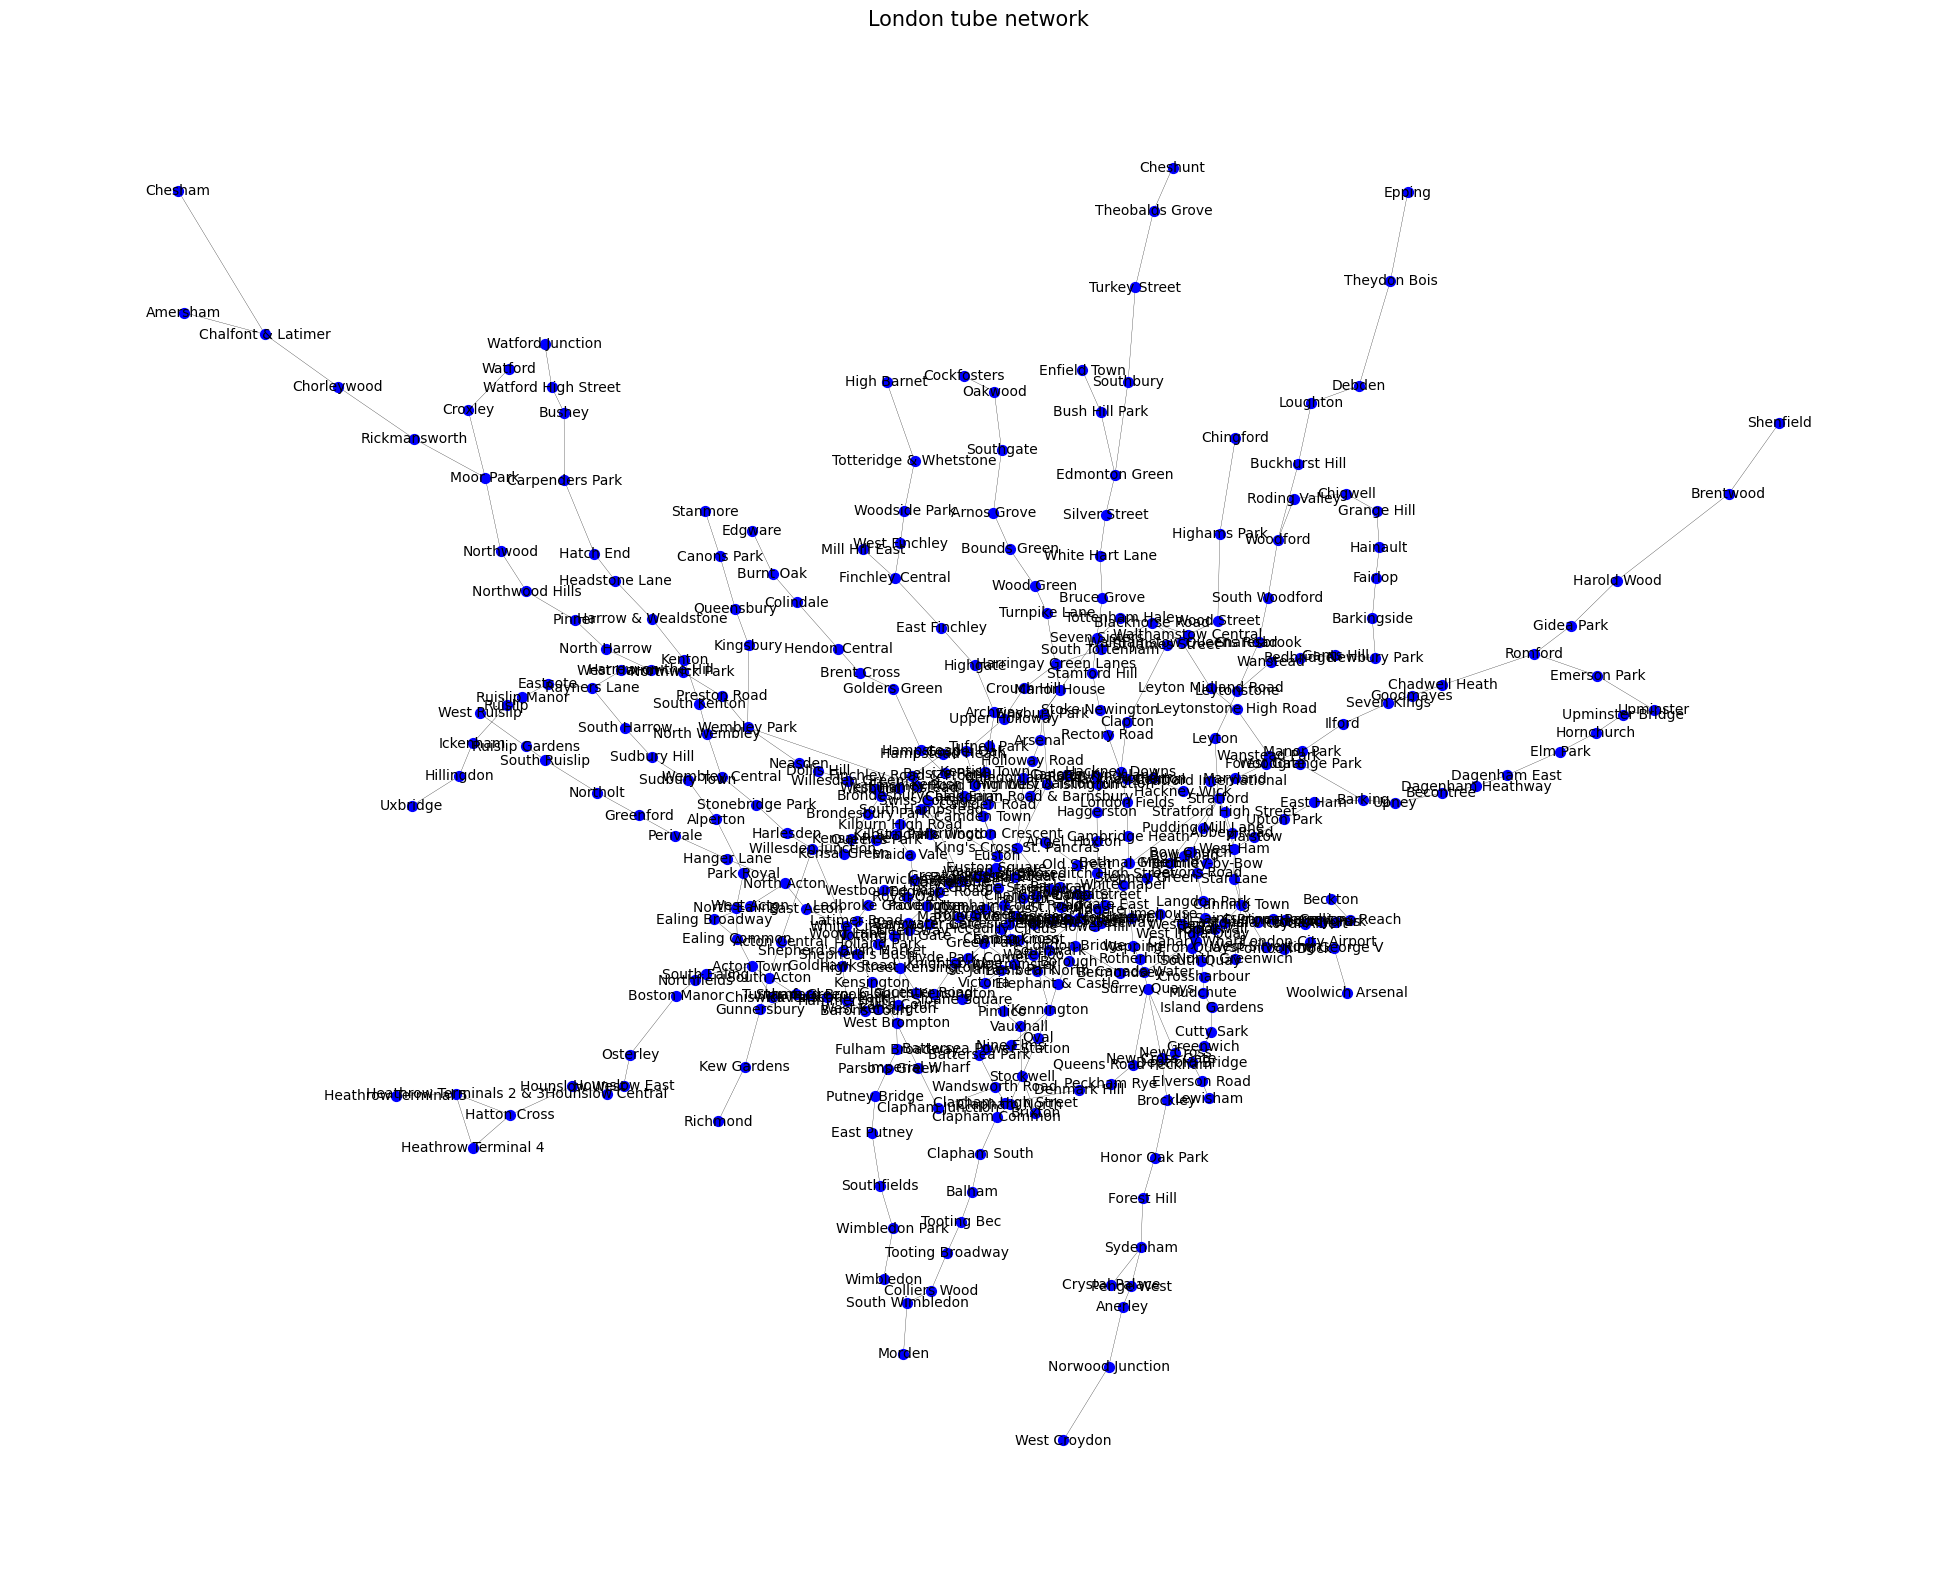

In [11]:
# Let's plot the tube network! 

# We can plot the tube network with the names of the stations as labels
fig, ax = plt.subplots(figsize=(25,20))


pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)

node_labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

In [12]:
 #We can print the dataframe from the shapefile to check the data
df = nx.to_pandas_edgelist(G)
df[0:10]

,source,target,flows,length,line_name
0,Wembley Park,Kingsbury,12356,2916.771558,Jubilee
1,Wembley Park,Neasden,6744,2353.165938,Jubilee
2,Wembley Park,Preston Road,36601,1419.735166,Metropolitan
3,Wembley Park,Finchley Road,55216,7266.373927,Metropolitan
4,Kingsbury,Queensbury,9419,1245.995234,Jubilee
5,Queensbury,Canons Park,6385,1693.307343,Jubilee
6,Canons Park,Stanmore,3624,1419.669476,Jubilee
7,Stratford,West Ham,91801,1673.509515,Jubilee
8,Stratford,Mile End,12010,2805.001392,Central
9,Stratford,Leyton,56082,2131.342926,Central


# Part 1: London’s underground resilience

## 1. Topological network

### 1.1 Centrality measures

#### 1.1.1 Degree Centrality on nodes

In [13]:
#  We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

In [14]:
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())

df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Stratford,0.0225
Bank and Monument,0.0200
King's Cross St. Pancras,0.0175
Baker Street,0.0175
Earl's Court,0.0150
Oxford Circus,0.0150
Liverpool Street,0.0150
Waterloo,0.0150
Green Park,0.0150
Canning Town,0.0150


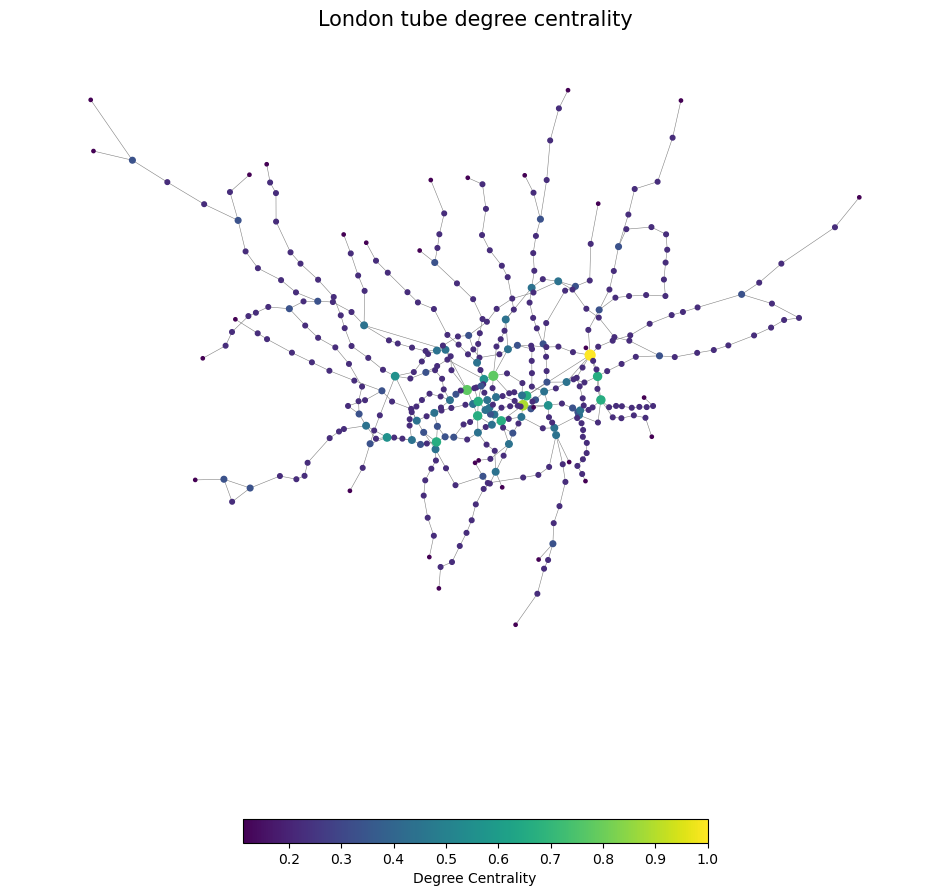

In [15]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]



# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)



plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube degree centrality",fontsize=15)
plt.show()

#### 1.1.2 Topological Betweenness Centrality on nodes

In [16]:
### Topological betweenness centrality:

#Let us compute the betweenness centrality for the network, without using weights:
bet_london_t=nx.betweenness_centrality(G, normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_t,'betweenness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())

df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
Stratford,23768.093434
Bank and Monument,23181.058947
Liverpool Street,21610.387049
King's Cross St. Pancras,20373.521465
Waterloo,19464.882323
Green Park,17223.622114
Euston,16624.275469
Westminster,16226.155916
Baker Street,15287.107612
Finchley Road,13173.758009


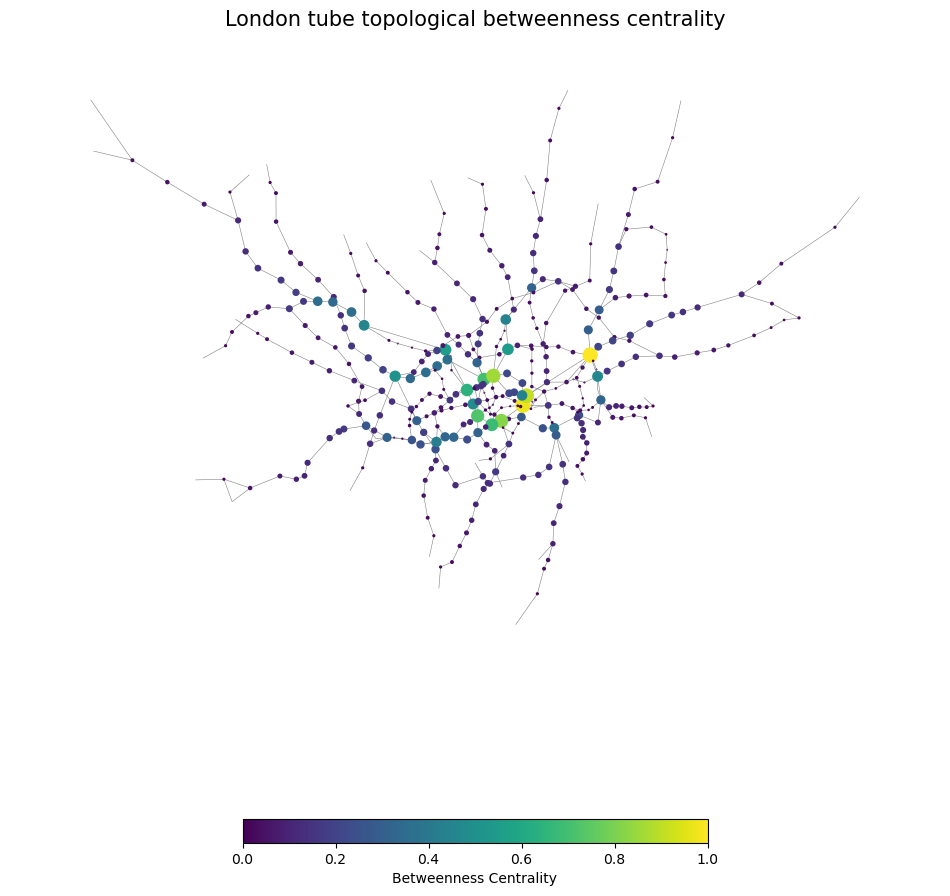

In [17]:
# Lets set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]

bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological betweenness centrality",fontsize=15)
plt.show()

#### 1.1.3 Topological Closeness Centrality on nodes

In [18]:
#topological closeness
clos_london_t=nx.closeness_centrality(G)

# Let us add the closeness centrality as attribute to the nodes in the graph
nx.set_node_attributes(G,clos_london_t,'closeness_t')

In [19]:
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())

df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


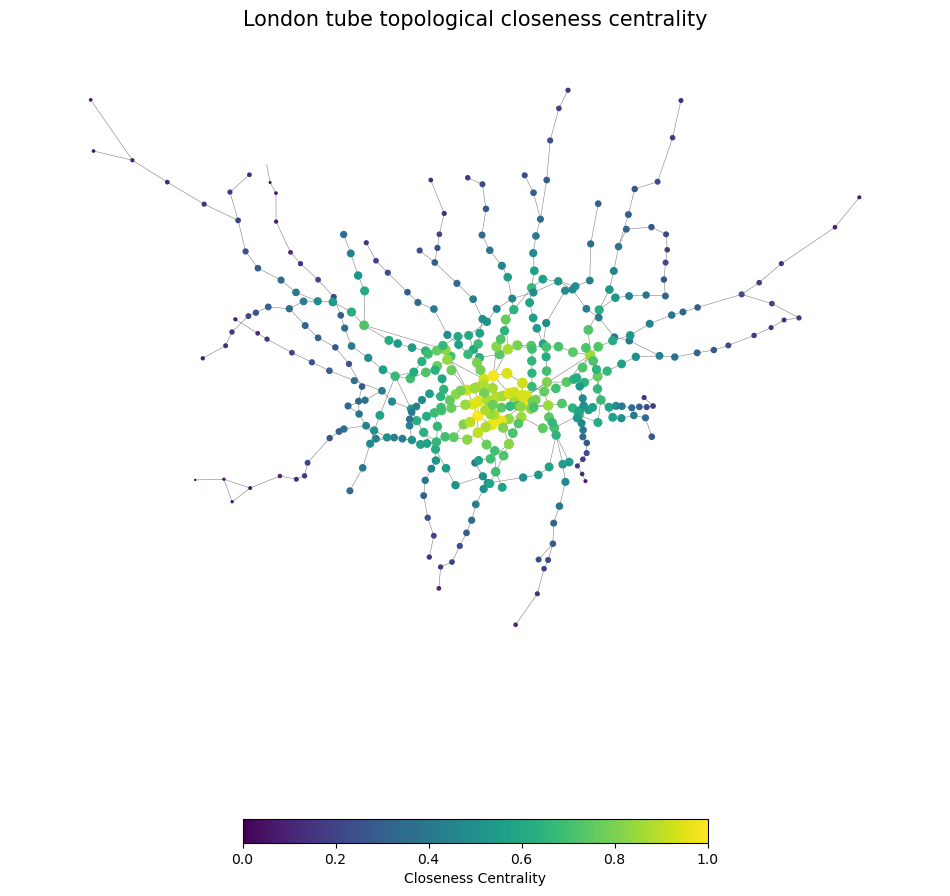

In [20]:
# Set color and size
# Closeness values
clos_val_t=[(i[1]['closeness_t']) for i in G.nodes(data=True)]


normalised_clos_t_color=[((i[1]['closeness_t']-min(clos_val_t))/(max(clos_val_t)-min(clos_val_t))) for i in G.nodes(data=True)]
clos_t_size=[((i[1]['closeness_t']-min(clos_val_t))/(max(clos_val_t)-min(clos_val_t))*50) for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

# pos=nx.spring_layout(G)
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
# nx.draw_networkx_labels(g_dad, pos,font_size=9,
#         font_color='black')
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= normalised_clos_t_color,
        node_size=clos_t_size )

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological closeness centrality",fontsize=15)
plt.show()

### 1.2 Measures to assess impact

#### 1.2.1 Network Efficiency

In [21]:
network_efficiency = nx.global_efficiency(G)

In [22]:
print("Network Efficiency:", network_efficiency)

Network Efficiency: 0.1012561935972123


#### 1.2.2 Largest Connected Component, LCC

In [23]:
largest_cc = max(nx.connected_components(G), key=len)
size_largest_cc = len(largest_cc)
print("Size of Largest Connected Component:", size_largest_cc)

Size of Largest Connected Component: 401


### 1.3 Node removal

#### 1.3.1 Setting functions

##### Centrality

In [24]:
# Function to calculate centrality and network influence (e.g., average path length)
# Degree Centrality on nodes function
def deg_cent_scores(G):
    return nx.degree_centrality(G)
    
# Topological Betweenness Centrality on nodes function
def bet_cent_scores(G):
    return nx.betweenness_centrality(G, normalized=False)

# Topological Closeness Centrality on nodes function
def clos_cent_scores(G):
    return nx.closeness_centrality(G)

##### Impact

In [25]:
# Network Efficiency
def network_efficiency(G):
    try:
        return nx.global_efficiency(G)
    except nx.NetworkXError:
        return float('inf')

# Largest Connected Component, LCC
def largest_connected_component(G):
    try:
        largest_cc = max(nx.connected_components(G), key=len)
        return len(largest_cc)
    except nx.NetworkXError:
        return float('inf')

##### Strategies

In [26]:
# Non-Sequential removal
def non_sequential_removal(G, centrality_func, impact_func, num_nodes=10):
    impacts = []
    # First calculate and add the impact of the initial network
    initial_impact = impact_func(G)
    impacts.append(initial_impact)

    # Initial centrality score
    initial_scores = centrality_func(G)
    # Arrange nodes in descending order by centrality score
    nodes_sorted_by_centrality = sorted(initial_scores, key=initial_scores.get, reverse=True)
    
    for node in nodes_sorted_by_centrality[:num_nodes]:
        # Remove node
        G.remove_node(node)
        # Calculate the network impact after a node is removed
        impact = impact_func(G)
        impacts.append(impact)
    
    return impacts

# Sequential removal
def sequential_removal(G, centrality_func, impact_func, num_nodes=10):
    impacts = []
    # First calculate and add the impact of the initial network
    initial_impact = impact_func(G)
    impacts.append(initial_impact)

    for _ in range(num_nodes):
        # Calculate the current centrality score
        current_scores = centrality_func(G)
        # Find the node with the highest score
        max_centrality_node = max(current_scores, key=current_scores.get)
        # Remove node
        G.remove_node(max_centrality_node)
        # Calculate the network impact after a node is removed
        impact = impact_func(G)
        impacts.append(impact)
    
    return impacts

#### A) Non-Sequential removal

In [27]:
# Degree-Network Efficiency
# Create a copy of the diagram to perform multiple operations on the original diagram
G_original = G.copy()
# Perform a non-sequential removal
non_sequential_results_deg_eff = non_sequential_removal(G_original.copy(), deg_cent_scores, network_efficiency)
# Output result
print("Non-sequential removal impacts_deg_eff:", non_sequential_results_deg_eff)

# Topological Betweenness-Network Efficiency
G_original = G.copy()
non_sequential_results_bet_eff = non_sequential_removal(G_original.copy(), bet_cent_scores, network_efficiency)
print("Non-sequential removal impacts_bet_eff:", non_sequential_results_bet_eff)

# Topological Closeness-Network Efficiency
G_original = G.copy()
non_sequential_results_clos_eff = non_sequential_removal(G_original.copy(), clos_cent_scores, network_efficiency)
print("Non-sequential removal impacts_clos_eff:", non_sequential_results_clos_eff)

# Degree-Largest Connected Component
G_original = G.copy()
non_sequential_results_deg_lcc = non_sequential_removal(G_original.copy(), deg_cent_scores, largest_connected_component)
print("Non-sequential removal impacts_deg_lcc:", non_sequential_results_deg_lcc)

# Topological Betweenness-Largest Connected Component
G_original = G.copy()
non_sequential_results_bet_lcc = non_sequential_removal(G_original.copy(), bet_cent_scores, largest_connected_component)
print("Non-sequential removal impacts_bet_lcc:", non_sequential_results_bet_lcc)

# Topological Closeness-Largest Connected Component
G_original = G.copy()
non_sequential_results_clos_lcc = non_sequential_removal(G_original.copy(), clos_cent_scores, largest_connected_component)
print("Non-sequential removal impacts_clos_lcc:", non_sequential_results_clos_lcc)

Non-sequential removal impacts_deg_eff: [0.1012561935972123, 0.08891736066510689, 0.08586164448742485, 0.08203328759057034, 0.07570039409751211, 0.07302243396164704, 0.06893502024058405, 0.06721932836875794, 0.06622091057392582, 0.06536196059296152, 0.06373592086177943]
Non-sequential removal impacts_bet_eff: [0.1012561935972123, 0.08891736066510689, 0.08586164448742485, 0.08496349266423939, 0.07849775440713821, 0.07594226578366223, 0.07415154167648695, 0.06820564659789057, 0.06765950327361094, 0.064700058053009, 0.06313903700825897]
Non-sequential removal impacts_clos_eff: [0.1012561935972123, 0.09918991960788402, 0.09487232544791133, 0.08793385149140875, 0.08737164566976727, 0.08485943799789313, 0.08278135073141742, 0.08258086417012774, 0.08260040537396239, 0.08262233108950982, 0.08166991436767818]
Non-sequential removal impacts_deg_lcc: [401, 379, 378, 377, 374, 371, 356, 355, 354, 352, 346]
Non-sequential removal impacts_bet_lcc: [401, 379, 378, 377, 371, 370, 369, 346, 345, 342, 3

#### B) Sequential removal

In [28]:
# Degree-Network Efficiency
# Reset the graph to its initial state
G_original = G.copy()

# Perform sequential removal
sequential_results_deg_eff = sequential_removal(G_original.copy(), deg_cent_scores, network_efficiency)

# Output result
print("Sequential removal impacts_deg_eff:", sequential_results_deg_eff)

# Topological Betweenness-Network Efficiency
G_original = G.copy()
sequential_results_bet_eff = sequential_removal(G_original.copy(), bet_cent_scores, network_efficiency)
print("Sequential removal impacts_bet_eff:", sequential_results_bet_eff)

# Topological Closeness-Network Efficiency
G_original = G.copy()
sequential_results_clos_eff = sequential_removal(G_original.copy(), clos_cent_scores, network_efficiency)
print("Sequential removal impacts_clos_eff:", sequential_results_clos_eff)

# Degree-Largest Connected Component
G_original = G.copy()
sequential_results_deg_lcc = sequential_removal(G_original.copy(), deg_cent_scores, largest_connected_component)
print("Sequential removal impacts_deg_lcc:", sequential_results_deg_lcc)

# Topological Betweenness-Largest Connected Component
G_original = G.copy()
sequential_results_bet_lcc = sequential_removal(G_original.copy(), bet_cent_scores, largest_connected_component)
print("Sequential removal impacts_bet_lcc:", sequential_results_bet_lcc)

# Topological Closeness-Largest Connected Component
G_original = G.copy()
sequential_results_clos_lcc = sequential_removal(G_original.copy(), clos_cent_scores, largest_connected_component)
print("Sequential removal impacts_clos_lcc:", sequential_results_clos_lcc)

Sequential removal impacts_deg_eff: [0.1012561935972123, 0.08891736066510689, 0.08586164448742485, 0.08203328759057034, 0.07570039409751211, 0.07039592695635104, 0.06940235301523284, 0.0677717604548151, 0.06593580277595987, 0.06506900122239155, 0.056747518813518014]
Sequential removal impacts_bet_eff: [0.1012561935972123, 0.08891736066510689, 0.08460293133575152, 0.08182895253292936, 0.07767794342812263, 0.07283234083472483, 0.053210203984026455, 0.05165629952389727, 0.0458442134055722, 0.04163076968121037, 0.0381637040943985]
Sequential removal impacts_clos_eff: [0.1012561935972123, 0.09918991960788402, 0.09443475025566316, 0.09181648060183005, 0.08542563066911478, 0.08054424756502003, 0.05810104159173278, 0.051883620553389555, 0.05035000093626794, 0.04439458727102797, 0.04295771061337044]
Sequential removal impacts_deg_lcc: [401, 379, 378, 377, 374, 360, 359, 358, 357, 355, 341]
Sequential removal impacts_bet_lcc: [401, 379, 378, 377, 376, 375, 227, 226, 196, 173, 170]
Sequential rem

#### Normalization

Largest Connected Component

In [29]:
def min_max_normalize(data):
    min_val = min(data)
    max_val = max(data)
    normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
    return normalized_data

# Merge all data
all_data_lcc = (sequential_results_deg_lcc + sequential_results_bet_lcc + 
            sequential_results_clos_lcc + non_sequential_results_deg_lcc + 
            non_sequential_results_bet_lcc + non_sequential_results_clos_lcc)

# Normalized the combined data
normalized_all_data_lcc = min_max_normalize(all_data_lcc)

# data length
lengths_lcc = [
    len(sequential_results_deg_lcc), len(sequential_results_bet_lcc),
    len(sequential_results_clos_lcc), len(non_sequential_results_deg_lcc),
    len(non_sequential_results_bet_lcc), len(non_sequential_results_clos_lcc)
]

# The segmented normalized data were returned to the original six groups
normalized_sequential_deg_lcc = normalized_all_data_lcc[:lengths_lcc[0]]
normalized_sequential_bet_lcc = normalized_all_data_lcc[lengths_lcc[0]:lengths_lcc[0]+lengths_lcc[1]]
normalized_sequential_clos_lcc = normalized_all_data_lcc[sum(lengths_lcc[:2]):sum(lengths_lcc[:3])]
normalized_non_sequential_deg_lcc = normalized_all_data_lcc[sum(lengths_lcc[:3]):sum(lengths_lcc[:4])]
normalized_non_sequential_bet_lcc = normalized_all_data_lcc[sum(lengths_lcc[:4]):sum(lengths_lcc[:5])]
normalized_non_sequential_clos_lcc = normalized_all_data_lcc[sum(lengths_lcc[:5]):]

# Output a set of normalized results for validation
print("Normalized Sequential removal impacts_deg_lcc:", normalized_sequential_deg_lcc)
print("Normalized Sequential removal impacts_bet_lcc:", normalized_sequential_bet_lcc)
print("Normalized Sequential removal impacts_clos_lcc:", normalized_sequential_clos_lcc)

print("Normalized Non-sequential removal impacts_deg_lcc:", normalized_non_sequential_deg_lcc)
print("Normalized Non-sequential removal impacts_bet_lcc:", normalized_non_sequential_bet_lcc)
print("Normalized Non-sequential removal impacts_clos_lcc:", normalized_non_sequential_clos_lcc)

Normalized Sequential removal impacts_deg_lcc: [1.0, 0.9047619047619048, 0.9004329004329005, 0.8961038961038961, 0.8831168831168831, 0.8225108225108225, 0.8181818181818182, 0.8138528138528138, 0.8095238095238095, 0.8008658008658008, 0.7402597402597403]
Normalized Sequential removal impacts_bet_lcc: [1.0, 0.9047619047619048, 0.9004329004329005, 0.8961038961038961, 0.8917748917748918, 0.8874458874458875, 0.24675324675324675, 0.24242424242424243, 0.11255411255411256, 0.012987012987012988, 0.0]
Normalized Sequential removal impacts_clos_lcc: [1.0, 0.9956709956709957, 0.9913419913419913, 0.987012987012987, 0.9826839826839827, 0.9783549783549783, 0.24242424242424243, 0.24242424242424243, 0.23809523809523808, 0.10822510822510822, 0.1038961038961039]
Normalized Non-sequential removal impacts_deg_lcc: [1.0, 0.9047619047619048, 0.9004329004329005, 0.8961038961038961, 0.8831168831168831, 0.8701298701298701, 0.8051948051948052, 0.8008658008658008, 0.7965367965367965, 0.7878787878787878, 0.76190476

Network Efficiency

In [30]:
# Merge all data
all_data_eff = (sequential_results_deg_eff + sequential_results_bet_eff + 
            sequential_results_clos_eff + non_sequential_results_deg_eff + 
            non_sequential_results_bet_eff + non_sequential_results_clos_eff)

# Normalized the combined data
normalized_all_data_eff = min_max_normalize(all_data_eff)

# data length
lengths_eff = [
    len(sequential_results_deg_eff), len(sequential_results_bet_eff),
    len(sequential_results_clos_eff), len(non_sequential_results_deg_eff),
    len(non_sequential_results_bet_eff), len(non_sequential_results_clos_eff)
]

# The segmented normalized data were returned to the original six groups
normalized_sequential_deg_eff = normalized_all_data_eff[:lengths_eff[0]]
normalized_sequential_bet_eff = normalized_all_data_eff[lengths_eff[0]:lengths_eff[0]+lengths_eff[1]]
normalized_sequential_clos_eff = normalized_all_data_eff[sum(lengths_eff[:2]):sum(lengths_eff[:3])]
normalized_non_sequential_deg_eff = normalized_all_data_eff[sum(lengths_eff[:3]):sum(lengths_eff[:4])]
normalized_non_sequential_bet_eff = normalized_all_data_eff[sum(lengths_eff[:4]):sum(lengths_eff[:5])]
normalized_non_sequential_clos_eff = normalized_all_data_eff[sum(lengths_eff[:5]):]

# Output a set of normalized results for validation
print("Normalized Sequential removal impacts_deg_eff:", normalized_sequential_deg_eff)
print("Normalized Sequential removal impacts_bet_eff:", normalized_sequential_bet_eff)
print("Normalized Sequential removal impacts_clos_eff:", normalized_sequential_clos_eff)

print("Normalized Non-sequential removal impacts_deg_eff:", normalized_non_sequential_deg_eff)
print("Normalized Non-sequential removal impacts_bet_eff:", normalized_non_sequential_bet_eff)
print("Normalized Non-sequential removal impacts_clos_eff:", normalized_non_sequential_clos_eff)

Normalized Sequential removal impacts_deg_eff: [1.0, 0.8044326190115684, 0.756000290508415, 0.6953218020381863, 0.5949470420158259, 0.5108725795407875, 0.49512468388874026, 0.46928020424833833, 0.4401807394257725, 0.4264421540505725, 0.29454876270638697]
Normalized Sequential removal impacts_bet_eff: [1.0, 0.8044326190115684, 0.736050005433403, 0.6920831430591035, 0.6262906987045087, 0.5494891232462807, 0.2384832173876561, 0.21385422473933327, 0.12173412987343232, 0.05495211259110713, 0.0]
Normalized Sequential removal impacts_clos_eff: [1.0, 0.9672500799126634, 0.8918818484528984, 0.85038293670499, 0.7490895817735722, 0.6717208942711231, 0.3160017563809257, 0.2174572055581857, 0.19314972254068294, 0.09875792230946258, 0.07598379072929332]
Normalized Non-sequential removal impacts_deg_eff: [1.0, 0.8044326190115684, 0.756000290508415, 0.6953218020381863, 0.5949470420158259, 0.5525020512258263, 0.4877175776177482, 0.46052429541655054, 0.44469962590834244, 0.4310854859729388, 0.4053131675

#### Line Chart

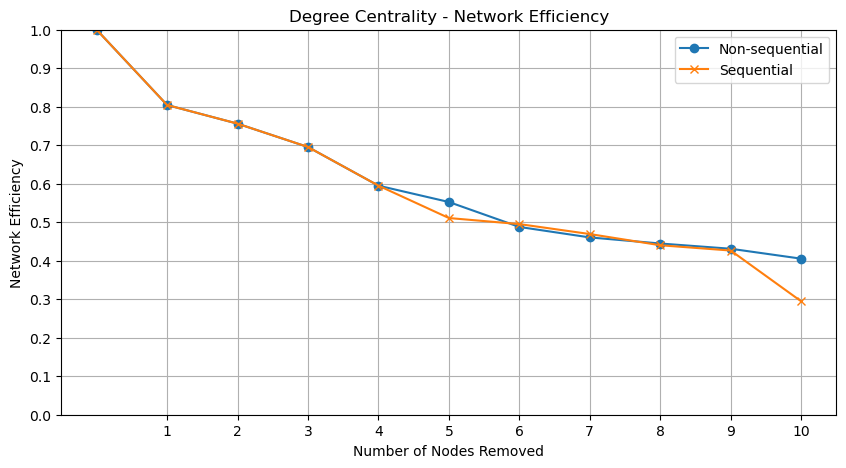

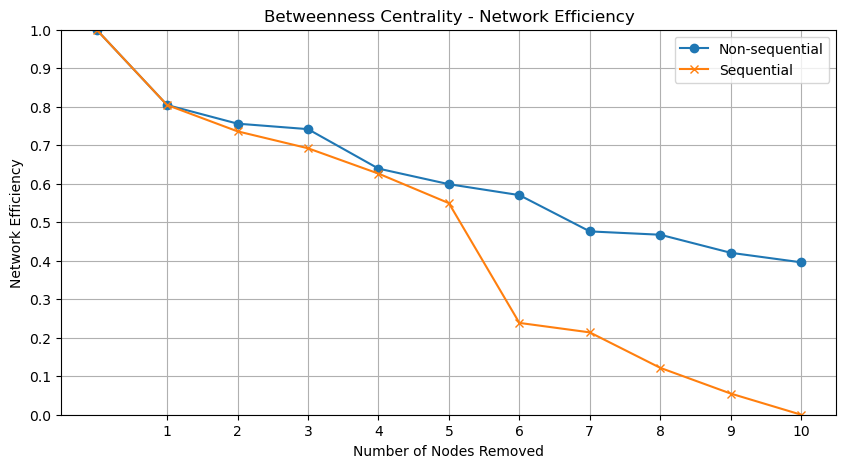

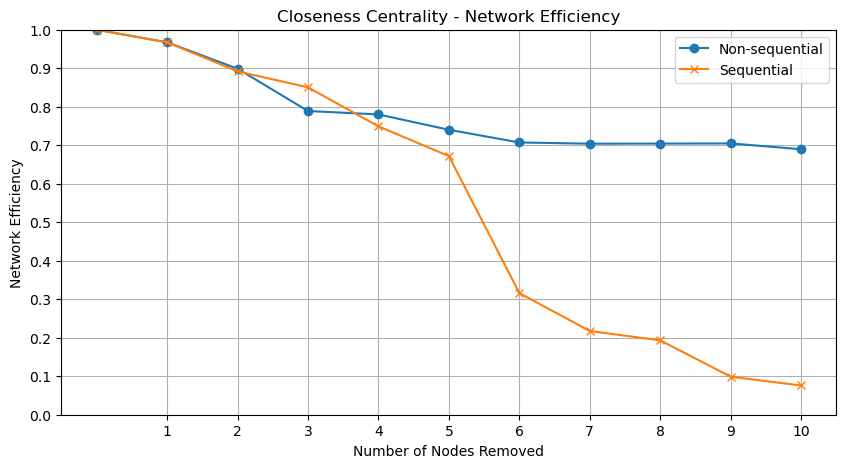

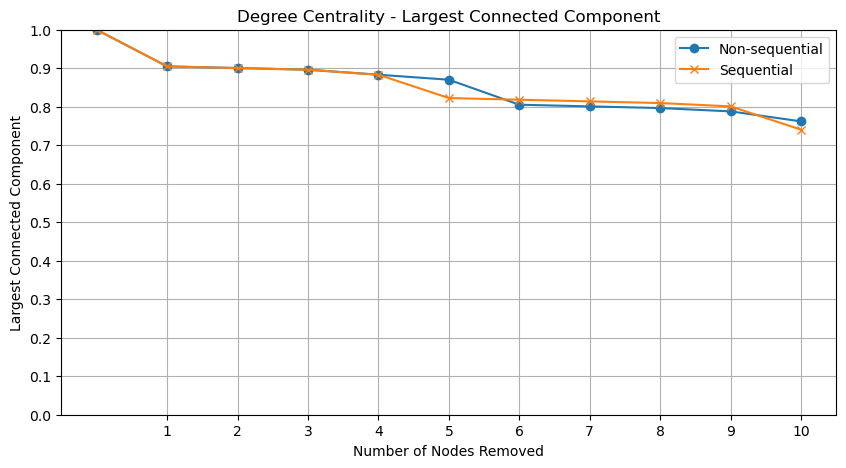

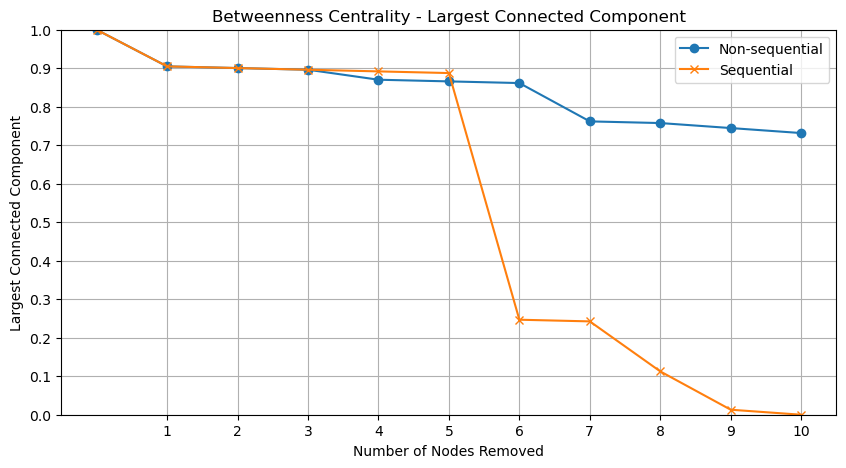

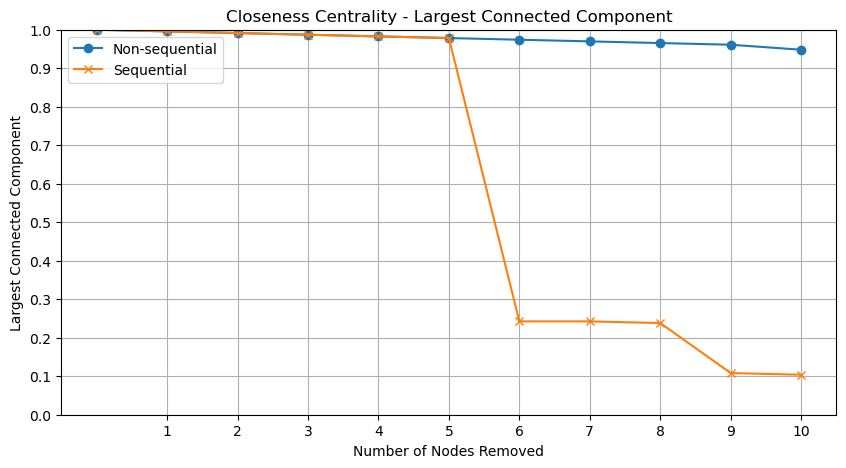

In [31]:
def plot_impacts(non_sequential_impacts, sequential_impacts, title, ylabel):
    x = list(range(1, len(non_sequential_impacts) + 1))
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, non_sequential_impacts, marker='o', label='Non-sequential')
    plt.plot(x, sequential_impacts, marker='x', label='Sequential')
    
    plt.title(title)
    plt.xlabel('Number of Nodes Removed')
    plt.ylabel(ylabel)
    plt.xticks([i for i in range(2, len(x) + 1)], [str(i) for i in range(1, len(x))])
    plt.yticks([i * 0.1 for i in range(0, 11)])  # Set y ticks from 0 to 1, with a step of 0.1
    plt.ylim(0, 1)  # Set y limits from 0 to 1
    plt.legend()
    plt.grid(True)
    plt.show()


plot_impacts(normalized_non_sequential_deg_eff, normalized_sequential_deg_eff, 'Degree Centrality - Network Efficiency', 'Network Efficiency')
plot_impacts(normalized_non_sequential_bet_eff, normalized_sequential_bet_eff, 'Betweenness Centrality - Network Efficiency', 'Network Efficiency')
plot_impacts(normalized_non_sequential_clos_eff, normalized_sequential_clos_eff, 'Closeness Centrality - Network Efficiency', 'Network Efficiency')
plot_impacts(normalized_non_sequential_deg_lcc, normalized_sequential_deg_lcc, 'Degree Centrality - Largest Connected Component', 'Largest Connected Component')
plot_impacts(normalized_non_sequential_bet_lcc, normalized_sequential_bet_lcc, 'Betweenness Centrality - Largest Connected Component', 'Largest Connected Component')
plot_impacts(normalized_non_sequential_clos_lcc, normalized_sequential_clos_lcc, 'Closeness Centrality - Largest Connected Component', 'Largest Connected Component')

## 2. Flows: weighted network

### 2.1 Old vs new measure

In [32]:
# Sequential removal with names of removal nodes
def sequential_removal1(G, centrality_func, impact_func, num_nodes=10):
    impacts = []
    removed_nodes = []  

 
    initial_impact = impact_func(G)
    impacts.append(initial_impact)

    for _ in range(num_nodes):

        current_scores = centrality_func(G)
        max_centrality_node = max(current_scores, key=current_scores.get)
        G.remove_node(max_centrality_node)
        removed_nodes.append(max_centrality_node)
        print(f"Removed node: {max_centrality_node}")
        impact = impact_func(G)
        impacts.append(impact)

    return impacts, removed_nodes  

In [33]:
# Topological Betweenness-Network Efficiency
G_original = G.copy()
sequential_results_bet_eff1 = sequential_removal1(G_original.copy(), bet_cent_scores, network_efficiency)
print("Sequential removal impacts_bet_eff:", sequential_results_bet_eff1)

Removed node: Stratford
Removed node: King's Cross St. Pancras
Removed node: Waterloo
Removed node: Bank and Monument
Removed node: Canada Water
Removed node: West Hampstead
Removed node: Earl's Court
Removed node: Shepherd's Bush
Removed node: Euston
Removed node: Baker Street
Sequential removal impacts_bet_eff: ([0.1012561935972123, 0.08891736066510689, 0.08460293133575152, 0.08182895253292936, 0.07767794342812263, 0.07283234083472483, 0.053210203984026455, 0.05165629952389727, 0.0458442134055722, 0.04163076968121037, 0.0381637040943985], ['Stratford', "King's Cross St. Pancras", 'Waterloo', 'Bank and Monument', 'Canada Water', 'West Hampstead', "Earl's Court", "Shepherd's Bush", 'Euston', 'Baker Street'])


In [34]:
### Weighted betweenness centrality:
#Let us compute the betweenness centrality for the network, considering the distance between stations:

bet_london_w = nx.betweenness_centrality(G, weight=lambda u, v, d: 1 / d['flows'] if d['flows'] > 0 else float('inf'), normalized=False)

# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_w,'betweenness_w')

In [35]:
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())

df['betweenness_w'] = pd.Series(nx.get_node_attributes(G, 'betweenness_w'))

df_sorted = df.sort_values(["betweenness_w"], ascending=False)
df_sorted[0:10]

,betweenness_w
Green Park,45311.620345
Bank and Monument,40317.741212
Waterloo,32720.649912
Westminster,30080.962295
Stratford,27759.262142
Liverpool Street,26848.579108
Bond Street,23188.980459
Euston,22600.517152
Oxford Circus,21453.463388
Warren Street,20140.612103


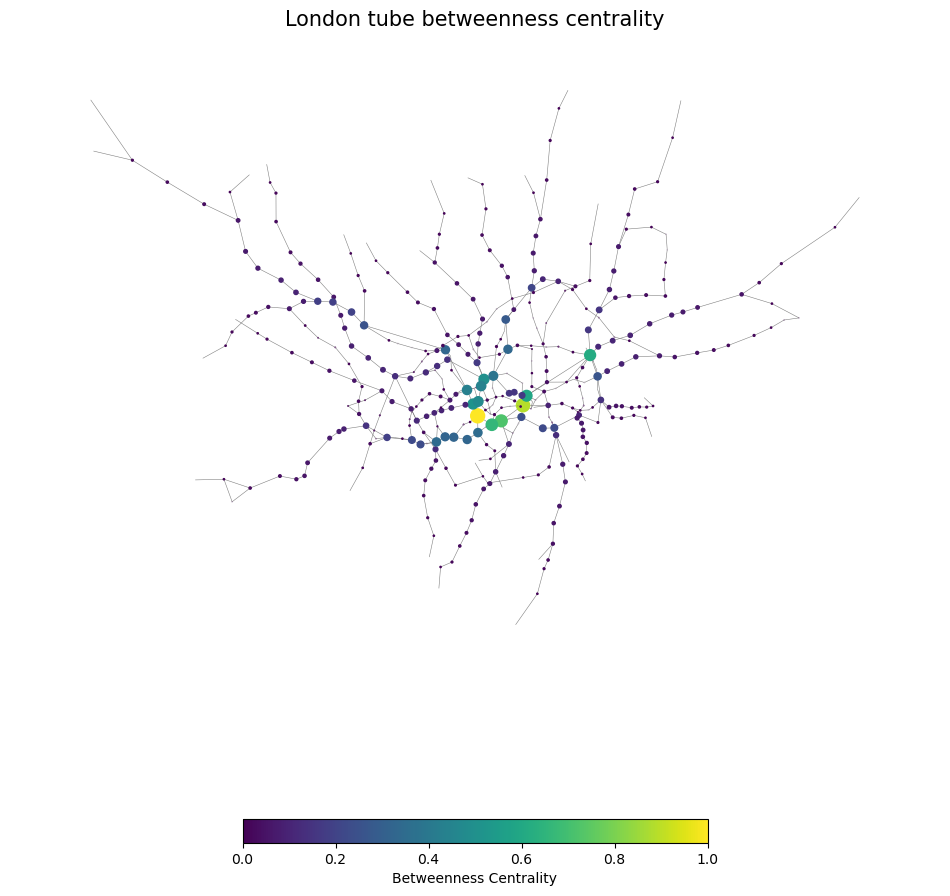

In [36]:
# Lets set colour and size of nodes according to betweenness values
betweenness_w_values=[(i[1]['betweenness_w']) for i in G.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in G.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values))*100 for i in G.nodes(data=True)]


# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube betweenness centrality",fontsize=15)
plt.show()

### 2.2 Impact measure with flows

#### 1.2.1 Network Efficiency

In [37]:
def global_efficiency_weighted(G):
    n = len(G)
    if n <= 1:
        return 0
    sum_of_inverses = 0.0
    for u in G:
        
        path_length_dict = nx.shortest_path_length(G, source=u, weight=lambda u, v, d: 1 / (d['flows'] if d['flows'] != 0 else 0.001))
        sum_of_inverses += sum(1 / path_length_dict[v] if path_length_dict[v] != 0 else 0 for v in G if v != u)
    return sum_of_inverses / (n * (n - 1))


print("Global Efficiency Weighted is:", global_efficiency_weighted(G))

Global Efficiency Weighted is: 2648.7211680298938


#### 1.2.2 Average Weighted Clustering Coefficient

In [38]:
clustering_coefficients = nx.clustering(G, weight='flows')
average_clustering_coefficient = sum(clustering_coefficients.values()) / len(clustering_coefficients)

print("Average Weighted Clustering Coefficient:", average_clustering_coefficient)

Average Weighted Clustering Coefficient: 0.0015791877116043108


### 2.3 Experiment with flows

#### 2.3.1 Setting functions

##### Centrality

In [39]:
### Weighted betweenness centrality:
def wbet_cent_scores(G):
    return nx.betweenness_centrality(G, weight=lambda u, v, d: 1 / d['flows'] if d['flows'] > 0 else float('inf'), normalized=False)

##### Impact

In [40]:
# Weighted Global Efficiency
def global_efficiency_weighted(G):
    try:
        n = len(G)
        if n <= 1:
            return 0
        sum_of_inverses = 0.0
        for u in G:
            # Check weights to prevent division by zero errors
            path_length_dict = nx.shortest_path_length(G, source=u, weight=lambda u, v, d: 1 / (d['flows'] if d['flows'] != 0 else 0.001))
            sum_of_inverses += sum(1 / path_length_dict[v] if path_length_dict[v] != 0 else 0 for v in G if v != u)
        return sum_of_inverses / (n * (n - 1))
    except nx.NetworkXError:
        return float('inf')

# Average Weighted Clustering Coefficient
def average_clustering_coefficient(G):
    try:
        clustering_coefficients = nx.clustering(G, weight='flows')
        return sum(clustering_coefficients.values()) / len(clustering_coefficients)
    except nx.NetworkXError:
        return float('inf')

##### Strategies

In [47]:
# Non-Sequential removal
def non_sequential_removal02(G, centrality_func, impact_func, num_nodes=3):
    impacts = []
    # First calculate and add the impact of the initial network
    initial_impact = impact_func(G)
    impacts.append(initial_impact)

    # Initial centrality score
    initial_scores = centrality_func(G)
    # Arrange nodes in descending order by centrality score
    nodes_sorted_by_centrality = sorted(initial_scores, key=initial_scores.get, reverse=True)
    
    for node in nodes_sorted_by_centrality[:num_nodes]:
        # Remove node
        G.remove_node(node)
        # Calculate the network impact after a node is removed
        impact = impact_func(G)
        impacts.append(impact)
    
    return impacts

# Sequential removal
def sequential_removal02(G, centrality_func, impact_func, num_nodes=3):
    impacts = []
    # First calculate and add the impact of the initial network
    initial_impact = impact_func(G)
    impacts.append(initial_impact)

    for _ in range(num_nodes):
        # Calculate the current centrality score
        current_scores = centrality_func(G)
        # Find the node with the highest score
        max_centrality_node = max(current_scores, key=current_scores.get)
        # Remove node
        G.remove_node(max_centrality_node)
        # Calculate the network impact after a node is removed
        impact = impact_func(G)
        impacts.append(impact)
    
    return impacts

# Sequential removal with names of removal nodes
def sequential_removal2(G, centrality_func, impact_func, num_nodes=3):
    impacts = []
    removed_nodes = []  

 
    initial_impact = impact_func(G)
    impacts.append(initial_impact)

    for _ in range(num_nodes):

        current_scores = centrality_func(G)
        max_centrality_node = max(current_scores, key=current_scores.get)
        G.remove_node(max_centrality_node)
        removed_nodes.append(max_centrality_node)
        print(f"Removed node: {max_centrality_node}")
        impact = impact_func(G)
        impacts.append(impact)

    return impacts, removed_nodes  

#### A) Non-Sequential removal

In [42]:
# Weighted Betweenness-Weighted Global Efficiency
G_original = G.copy()
non_sequential_results_wbet_glo = non_sequential_removal02(G_original.copy(), wbet_cent_scores, global_efficiency_weighted)
print("Non-sequential removal impacts_wbet_glo:", non_sequential_results_wbet_glo)

# Weighted Betweenness-Average Weighted Clustering Coefficient
G_original = G.copy()
non_sequential_results_wbet_waclu = non_sequential_removal02(G_original.copy(), wbet_cent_scores, average_clustering_coefficient)
print("Non-sequential removal impacts_wbet_waclu:", non_sequential_results_wbet_waclu)

Non-sequential removal impacts_wbet_glo: [2648.7211680298938, 2387.1023349284264, 2062.5409966488273, 1970.779082185686]
Non-sequential removal impacts_wbet_waclu: [0.0015791877116043108, 0.0013181475470089986, 0.001083463543547776, 0.0012122084677991347]


#### B) Sequential removal

In [43]:
# Weighted Betweenness-Weighted Global Efficiency
G_original = G.copy()
sequential_results_wbet_glo = sequential_removal02(G_original.copy(), wbet_cent_scores, global_efficiency_weighted)
print("sequential removal impacts_wbet_glo:", sequential_results_wbet_glo)

# Weighted Betweenness-Average Weighted Clustering Coefficient
G_original = G.copy()
sequential_results_wbet_waclu = sequential_removal02(G_original.copy(), wbet_cent_scores, average_clustering_coefficient)
print("sequential removal impacts_wbet_waclu:", sequential_results_wbet_waclu)

sequential removal impacts_wbet_glo: [2648.7211680298938, 2387.1023349284264, 2062.5409966488273, 1699.7976905546805]
sequential removal impacts_wbet_waclu: [0.0015791877116043108, 0.0013181475470089986, 0.001083463543547776, 0.0010906626235442838]


#### Normalization

Weighted Global Efficiency

In [44]:
# Merge all data
all_data_glo = (sequential_results_wbet_glo + non_sequential_results_wbet_glo)

# Normalized the combined data
normalized_all_data_glo = min_max_normalize(all_data_glo)

# data length
lengths_glo = [
    len(sequential_results_wbet_glo), len(non_sequential_results_wbet_glo)
]

# The segmented normalized data were returned to the original six groups
normalized_sequential_results_wbet_glo = normalized_all_data_glo[:lengths_glo[0]]
normalized_non_sequential_results_wbet_glo = normalized_all_data_glo[lengths_glo[0]:lengths_glo[0]+lengths_glo[1]]


# The segmented normalized data were returned to the original six groups
print("Normalized sequential removal impacts_wbet_glo:", normalized_sequential_results_wbet_glo)

print("Normalized Non-sequential removal impacts_wbet_glo:", normalized_non_sequential_results_wbet_glo)

Normalized sequential removal impacts_wbet_glo: [1.0, 0.7242993357087626, 0.3822682383823958, 0.0]
Normalized Non-sequential removal impacts_wbet_glo: [1.0, 0.7242993357087626, 0.3822682383823958, 0.28556716960149603]


Average Weighted Clustering Coefficient

In [45]:
# Merge all data
all_data_waclu = (sequential_results_wbet_waclu + non_sequential_results_wbet_waclu)

# Normalized the combined data
normalized_all_data_waclu = min_max_normalize(all_data_waclu)

# data length
lengths_waclu = [
    len(sequential_results_wbet_waclu), len(non_sequential_results_wbet_waclu)
]

# The segmented normalized data were returned to the original six groups
normalized_sequential_results_wbet_waclu = normalized_all_data_waclu[:lengths_waclu[0]]
normalized_non_sequential_results_wbet_waclu = normalized_all_data_waclu[lengths_waclu[0]:lengths_waclu[0]+lengths_waclu[1]]


# Output a set of normalized results for validation
print("Normalized sequential removal impacts_wbet_waclu:", normalized_sequential_results_wbet_waclu)

print("Normalized Non-sequential removal impacts_wbet_waclu:", normalized_non_sequential_results_wbet_waclu)

Normalized sequential removal impacts_wbet_waclu: [1.0, 0.4734165057582146, 0.0, 0.014522350251212113]
Normalized Non-sequential removal impacts_wbet_waclu: [1.0, 0.4734165057582146, 0.0, 0.25971080804088614]


#### Line Chart

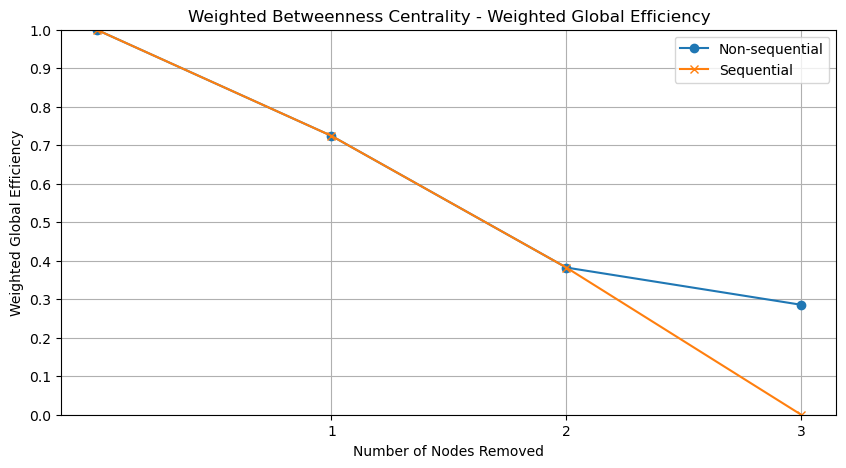

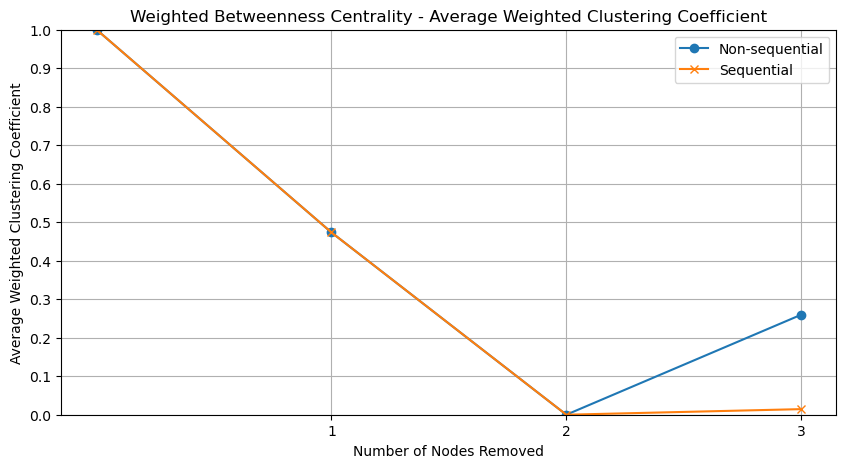

In [46]:
def plot_impacts(non_sequential_impacts, sequential_impacts, title, ylabel):
    x = list(range(1, len(non_sequential_impacts) + 1))
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, non_sequential_impacts, marker='o', label='Non-sequential')
    plt.plot(x, sequential_impacts, marker='x', label='Sequential')
    
    plt.title(title)
    plt.xlabel('Number of Nodes Removed')
    plt.ylabel(ylabel)
    plt.xticks([i for i in range(2, len(x) + 1)], [str(i) for i in range(1, len(x))])
    plt.yticks([i * 0.1 for i in range(0, 11)])  # Set y ticks from 0 to 1, with a step of 0.1
    plt.ylim(0, 1)  # Set y limits from 0 to 1
    plt.legend()
    plt.grid(True)
    plt.show()


plot_impacts(normalized_non_sequential_results_wbet_glo, normalized_sequential_results_wbet_glo, 'Weighted Betweenness Centrality - Weighted Global Efficiency', 'Weighted Global Efficiency')
plot_impacts(normalized_non_sequential_results_wbet_waclu, normalized_sequential_results_wbet_waclu, 'Weighted Betweenness Centrality - Average Weighted Clustering Coefficient', 'Average Weighted Clustering Coefficient')


In [48]:
# Weighted Betweenness-Weighted Global Efficiency
G_original = G.copy()
sequential_results_wbet_glo2 = sequential_removal2(G_original.copy(), wbet_cent_scores, global_efficiency_weighted)
print("sequential removal impacts_wbet_glo:", sequential_results_wbet_glo2)

Removed node: Green Park
Removed node: Bank and Monument
Removed node: King's Cross St. Pancras
sequential removal impacts_wbet_glo: ([2648.7211680298938, 2387.1023349284264, 2062.5409966488273, 1699.7976905546805], ['Green Park', 'Bank and Monument', "King's Cross St. Pancras"])


# Part 2: Spatial Interaction models

## 3. Models and calibration

### 3.1 Spatial interaction models

### 3.2 Calibration of model

#### 3.2.1 Create OD matrix

In [ ]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [ ]:
#read in the london tube flows
london_network = pd.read_csv("london_flows.csv")

In [ ]:
london_network.head(10)

In [ ]:
print(london_network.columns.tolist())

In [ ]:
#show the actual flows between stations
london_network_mat = pd.pivot_table(london_network, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
#show the data
london_network_mat

#### 3.2.2 Doubly Constrained Model

Inverse Power

In [ ]:
london_network['log_distance'] = np.log(london_network['distance'])

In [ ]:
#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form1 = 'flows ~ station_destination + station_origin + log_distance-1'
#run a doubly constrained sim
doubSim1 = smf.glm(formula = dbl_form, data=london_network, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim1.summary())

In [ ]:
#get the estimates
london_network["doubsimfitted1"] = np.round(doubSim1.mu)
#here's the matrix
london_network_mat2 = london_network.pivot_table(values ="doubsimfitted1", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
london_network_mat2

In [ ]:
CalcRSqaured(london_network["flows"],london_network["doubsimfitted1"])

In [ ]:
CalcRMSE(london_network["flows"],london_network["doubsimfitted1"])

Negative Exponential

In [ ]:
#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form = 'flows ~ station_destination + station_origin + distance-1'
#run a doubly constrained sim
doubSim = smf.glm(formula = dbl_form, data=london_network, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim.summary())

In [ ]:
#get the estimates
london_network["doubsimfitted"] = np.round(doubSim.mu)
#here's the matrix
london_network_mat3 = london_network.pivot_table(values ="doubsimfitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
london_network_mat3

In [ ]:
CalcRSqaured(london_network["flows"],london_network["doubsimfitted"])

In [ ]:
CalcRMSE(london_network["flows"],london_network["doubsimfitted"])

In [ ]:
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd#

In [ ]:
beta = -doubSim.params[-1]
print(beta)

## 4. Scenarios

### 4.1 Scenario A

In [ ]:
# Use the beta we got from the negative exponential model
beta = -doubSim.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
london_network = balance_doubly_constrained(london_network,'station_origin','station_destination','population','jobs','distance',-beta,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
london_network['SIM_est_exp'] = np.round(london_network['population'] * london_network['Ai_exp'] * london_network['jobs'] * london_network['Bj_exp'] * 
                                   np.exp(london_network['distance']*-beta))
# Check out the matrix
london_network.pivot_table(values='SIM_est_exp',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

In [ ]:
CalcRSqaured(london_network["flows"],london_network["SIM_est_exp"])

In [ ]:
CalcRMSE(london_network["flows"],london_network["SIM_est_exp"])

Adjusting the Canary Wharf employment scenario

In [ ]:
# Assuming london_network is the DataFrame from which we want to extract unique station_destination rows
london_network_temp = london_network.drop_duplicates(subset='station_destination', keep='first')

# Now london_network_temp contains unique rows based on the 'station_destination' column
london_network_temp

In [ ]:
# Calculate the total jobs before adjustments
total_jobs_before = london_network_temp['jobs'].sum()
# Apply a 50% reduction to jobs at Canary Wharf
london_network_temp.loc[london_network_temp['station_destination'] == 'Canary Wharf', 'jobs'] *= 0.5
# Calculate the reduction in jobs for Canary Wharf
canary_wharf_jobs_reduction = total_jobs_before - london_network_temp['jobs'].sum()
# Distribute this reduction proportionally across other destinations
london_network_temp['proportion'] = london_network_temp['jobs'] / london_network_temp['jobs'].sum()
london_network_temp['adjusted_jobs'] = london_network_temp['jobs'] + (canary_wharf_jobs_reduction * london_network_temp['proportion'])
# Because we want the adjusted jobs to be integers and sum up to the original total, we will round and then adjust
london_network_temp['adjusted_jobs'] = london_network_temp['adjusted_jobs'].round().astype(int)
# Correct any rounding discrepancies
adjustment = total_jobs_before - london_network_temp['adjusted_jobs'].sum()
while adjustment != 0:
    for index, row in london_network_temp.iterrows():
        if adjustment > 0 and row['station_destination'] != 'Canary Wharf':
            london_network_temp.at[index, 'adjusted_jobs'] += 1
            adjustment -= 1
        elif adjustment < 0 and row['station_destination'] != 'Canary Wharf' and row['adjusted_jobs'] > 0:
            london_network_temp.at[index, 'adjusted_jobs'] -= 1
            adjustment += 1
        if adjustment == 0:
            break
# Drop the temporary 'proportion' column
london_network_temp.drop(columns=['proportion'], inplace=True)

# Check the totals after adjustment to ensure they match the original total jobs
total_jobs_after = london_network_temp['adjusted_jobs'].sum()

# Return the adjusted dataframe and the sum of jobs after adjustment for verification
total_jobs_before, total_jobs_after

In [ ]:
# We will merge the 'adjusted_jobs' column from london_network_temp into the london_network DataFrame based on 'station_destination'
london_network = london_network.merge(london_network_temp[['station_destination', 'adjusted_jobs']], on='station_destination', how='left')

# Now, london_network will have an additional column 'adjusted_jobs' which matches the 'station_destination' from london_network_temp
london_network

Update the prediction model and generate the traffic matrix

In [ ]:
# Use the beta we got from the negative exponential model
beta = -doubSim.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
london_network = balance_doubly_constrained(london_network,'station_origin','station_destination','population','adjusted_jobs','distance',-beta,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
london_network['SIM_est_exp1'] = np.round(london_network['population'] * london_network['Ai_exp'] * london_network['adjusted_jobs'] * london_network['Bj_exp'] *
                                   np.exp(london_network['distance']*-beta))
# Check out the matrix
london_network_mat4 = london_network.pivot_table(values='SIM_est_exp1',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)
london_network_mat4

### 4.2 Scenario B

In [ ]:
beta2 = (-doubSim.params[-1]) * 1.2
beta2

In [ ]:
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
london_network = balance_doubly_constrained(london_network,'station_origin','station_destination','population','jobs','distance',-beta2,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
london_network['SIM_est_exp2'] = np.round(london_network['population'] * london_network['Ai_exp'] * london_network['jobs'] * london_network['Bj_exp'] * 
                                   np.exp(london_network['distance']*-beta2))
# Check out the matrix
london_network_mat5 = london_network.pivot_table(values='SIM_est_exp2',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)
london_network_mat5

In [ ]:
beta3 = (-doubSim.params[-1]) * 2
beta3

In [ ]:
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
london_network = balance_doubly_constrained(london_network,'station_origin','station_destination','population','jobs','distance',-beta3,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
london_network['SIM_est_exp3'] = np.round(london_network['population'] * london_network['Ai_exp'] * london_network['jobs'] * london_network['Bj_exp'] * 
                                   np.exp(london_network['distance']*-beta3))
# Check out the matrix
london_network_mat6 = london_network.pivot_table(values='SIM_est_exp3',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)
london_network_mat6

### 4.3 Analysis

In [ ]:
# Computed difference matrix
diff_mat4 = london_network_mat4 - london_network_mat
diff_mat5 = london_network_mat5 - london_network_mat
diff_mat6 = london_network_mat6 - london_network_mat


# Calculate total flow change
total_change_mat4 = np.sum(diff_mat4)
total_change_mat5 = np.sum(diff_mat5)
total_change_mat6 = np.sum(diff_mat6)

# Calculate the total flow change in absolute value
total_abs_change_mat4 = np.sum(np.abs(diff_mat4))
total_abs_change_mat5 = np.sum(np.abs(diff_mat5))
total_abs_change_mat6 = np.sum(np.abs(diff_mat6))

# Calculate the average absolute change
mean_abs_change_mat4 = np.mean(np.abs(diff_mat4))
mean_abs_change_mat5 = np.mean(np.abs(diff_mat5))
mean_abs_change_mat6 = np.mean(np.abs(diff_mat6))


# Calculate statistical distribution parameters
mean_mat = np.mean(london_network_mat)
median_mat = np.median(london_network_mat)
std_mat = np.std(london_network_mat)

mean_mat4 = np.mean(london_network_mat4)
median_mat4 = np.median(london_network_mat4)
std_mat4 = np.std(london_network_mat4)

mean_mat5 = np.mean(london_network_mat5)
median_mat5 = np.median(london_network_mat5)
std_mat5 = np.std(london_network_mat5)

mean_mat6 = np.mean(london_network_mat6)
median_mat6 = np.median(london_network_mat6)
std_mat6 = np.std(london_network_mat6)


# Print or store the result in a DataFrame
results = pd.DataFrame({
    'Metric': ['Total Change', 'Total Abs Change', 'Mean Abs Change', 'Mean', 'Median', 'Std'],
    'Mat4': [total_change_mat4, total_abs_change_mat4, mean_abs_change_mat4, mean_mat4, median_mat4, std_mat4],
    'Mat5': [total_change_mat5, total_abs_change_mat5, mean_abs_change_mat5, mean_mat5, median_mat5, std_mat5],
    'Mat6': [total_change_mat6, total_abs_change_mat6, mean_abs_change_mat6, mean_mat6, median_mat6, std_mat6]
})

print(results)